In [74]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.utils.multiclass import unique_labels

from source import load_avenio_files
from transform import ClassifierAsTransformer, clean_mutation_columns, dummy_encode_mutations, get_top_correlated, mutation_train_test_split, patient_allele_frequencies


RANDOM_STATE = 1234
np.random.seed(RANDOM_STATE)

In [2]:
# Load data from spreadsheet and SPSS files.
mutation_data_frame, phenotypes = load_avenio_files()

In [3]:
# Vocabulary is the entire dataset, not only training set. Otherwise we run into problems during inference.
gene_vocabulary = mutation_data_frame['Gene'].unique()
allele_columns = ["T0: Allele \nFraction", "T1: Allele Fraction"]

# raise Exception('Check allele columns!')

# Convert particular columns to numbers and drop rows with missing data.
mutation_data_frame = clean_mutation_columns(mutation_data_frame)

In [4]:
def f_t(t_0, t_1):
    return (t_1 - t_0) / t_0

In [5]:
patient_mutation_frequencies = patient_allele_frequencies(mutation_data_frame, gene_vocabulary, f_t)

In [6]:
# Phenotype features that serve as input for the model.
phenotype_features = [
    "gender",
    "leeftijd",
    "stage",
    "therapyline",
    "smokingstatus",
    "Systemischetherapie",
    "histology_grouped",
    "lymfmeta",
    "brainmeta",
    "adrenalmeta",
    "livermeta",
    "lungmeta",
    "skeletonmeta",
]

# Phenotype labels that we wish to predict.
phenotype_labels = [
    # Labels:
    "Clinical_Response",
    "response_grouped",
    "progressie",
]
# The columns to extract from the SPSS file.
phenotypes_to_keep = phenotype_features + phenotype_labels

# From those listed above, the following columns are categorical (not counting the labels).
categorical_input_columns = [
    "gender",
    "stage",
    "therapyline",
    "smokingstatus",
    "Systemischetherapie",
    "histology_grouped",
    "lymfmeta",
    "brainmeta",
    "adrenalmeta",
    "livermeta",
    "lungmeta",
    "skeletonmeta",
]
# Combine mutation data and phenotype data.
X = pd.merge(
    left=patient_mutation_frequencies,
    right=phenotypes[phenotypes_to_keep],
    left_index=True,
    right_index=True,
)

In [7]:
# Extract the labels for the classifier.
y_resp = X.pop('Clinical_Response')
y_resp_gp = X.pop('response_grouped')
y_prog = X.pop('progressie')

Train-test split

In [8]:
f_test = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y_resp, test_size=f_test, random_state=RANDOM_STATE)

## Transformation pipeline
Turn categorical data to integers.

In [9]:
preprocess = ColumnTransformer([
    ("LabelEncoder", OrdinalEncoder(), categorical_input_columns),
    ],
    remainder='passthrough',
)

Classification algorithms:

In [10]:
tree_classifier = DecisionTreeClassifier(random_state=RANDOM_STATE, max_depth=4)
forest_classifier = RandomForestClassifier(random_state=RANDOM_STATE, n_estimators=50, max_depth=4)
gb_classifier = GradientBoostingClassifier(random_state=RANDOM_STATE, n_estimators=50)

Build entire processing pipeline, including a function to single out specific columns.

In [11]:
classifier_names = ['tree', 'forest', 'gradient boost']
def build_pipelines(column_selection_function):
    # Select particular columns, don't convert to NumPy (validate=False).
    column_selector = FunctionTransformer(column_selection_function, validate=False)
    p_tree = Pipeline(steps=[
        ("select_columns", column_selector),
        ("transform_columns", preprocess), 
        ("classify", tree_classifier),
    ])
    p_forest = Pipeline(steps=[
        ("select_columns", column_selector),
        ("transform_columns", preprocess), 
        ("classify", forest_classifier),
    ])
    p_gradient_boost = Pipeline(steps=[
        ("select_columns", column_selector),
        ("transform_columns", preprocess), 
        ("classify", gb_classifier),
    ])
    return p_tree, p_forest, p_gradient_boost

In [12]:
def generate_feature_names(categorical_column_names, column_names):
    """
    Re-order column names to match the pipeline transformation.
    """ 
    # `ColumnTransformer` moves all the categorical data to the front of the matrix.
    new_column_order = categorical_column_names.copy()
    # Concatenate the columns that are left untouched.
    for column in column_names:
        if column not in categorical_column_names:
            new_column_order.append(column)
    return new_column_order

In [75]:
def compare_pipelines(pipelines, plot=False):
    if plot:
        f, axs = plt.subplots(1, len(pipelines))
        
    pipeline_scores = []
    for i, p in enumerate(pipelines):
        # Fit to training data.
        p.fit(X_train, y_train)
        # Calculate training and testing scores.
        pipeline_scores.append([p.score(X_train, y_train), p.score(X_test, y_test)])
        if plot:
            M = confusion_matrix(y_test, p.predict(X_test))
            axs[i].imshow(M)
            print(M)
            
    return pd.DataFrame(pipeline_scores, columns=['train acc.', 'test acc.'])

### Phenotype only
Single out phenotype features (ignore mutation information for the moment):

In [76]:
def select_phenotype_columns(X):
    """
    Ignore mutaton data.
    """ 
    return X[phenotype_features]

Generate pipelines for the various models.

In [77]:
pipelines = build_pipelines(select_phenotype_columns)

[[ 0  1  0  0  0]
 [ 0 10  5  0  2]
 [ 0  2  0  0  2]
 [ 0  2  1  0  0]
 [ 0  0  3  0  4]]
[[ 0  1  0  0  0]
 [ 0 13  1  0  3]
 [ 0  3  0  0  1]
 [ 0  3  0  0  0]
 [ 0  2  0  0  5]]
[[ 0  1  0  0  0]
 [ 0 11  1  0  5]
 [ 0  3  0  0  1]
 [ 0  3  0  0  0]
 [ 0  2  0  0  5]]


,train acc.,test acc.
tree,0.767123,0.4375
forest,0.849315,0.5625
gradient boost,0.972603,0.5000


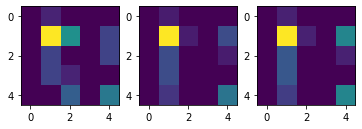

In [78]:
results_pheno_only = compare_pipelines(pipelines, True)
results_pheno_only.index = classifier_names
results_pheno_only

In [17]:
# First pipeline contains decision tree classifier.
name, tree_classifier = pipelines[0].steps[-1]
# Generate names of columns after the pipeline transformation.
new_column_names = generate_feature_names(categorical_input_columns, phenotype_features)

In [18]:
import graphviz

dot_data = export_graphviz(
    tree_classifier, 
    out_file=None,
    filled=True,
    feature_names=new_column_names,
    class_names=tree_classifier.classes_,
) 
graph = graphviz.Source(dot_data)


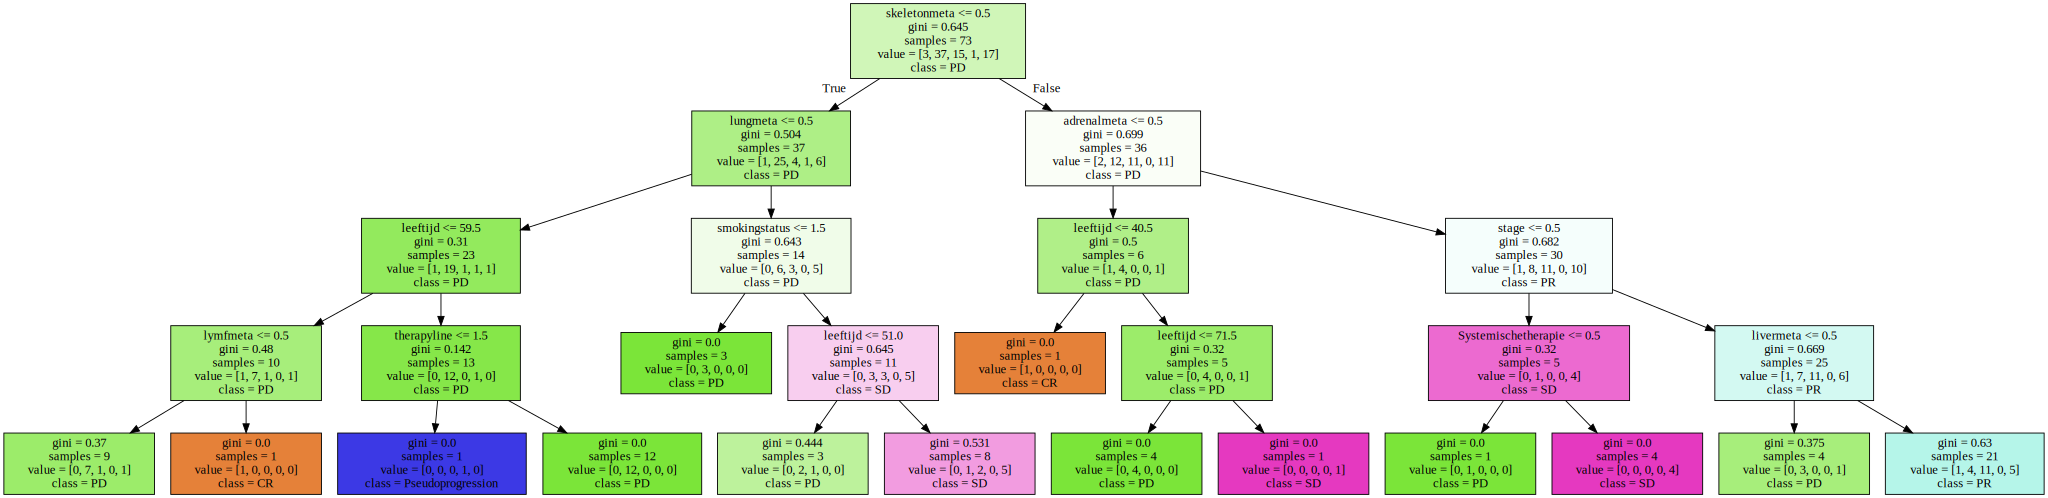

In [19]:
graph

### Mutation data only

In [20]:
def select_mutation_columns(X):
    """
    Select mutation columns only.
    """ 
    return X[patient_mutation_frequencies.columns]

Apart from all mutations, lets also focus on a small subset of mutations that occur rather frequently.

In [21]:
# Thresshold: genes must occur at least this many times.
LAMBDA = 6
# What elements are non-zero?
non_zero_values = patient_mutation_frequencies[patient_mutation_frequencies != 0]
# Pick columns that have at least `LAMBDA` occurences.
gene_thressholded = non_zero_values.count() >= LAMBDA
genes_to_pick = gene_thressholded.index[gene_thressholded]
frequent_mutations = genes_to_pick.values
frequent_mutations

array(['TP53', 'KRAS', 'CDKN2A', 'BRAF', 'NFE2L2', 'PIK3CA'], dtype=object)

In [22]:
def select_frequent_mutation_columns(X):
    """
    Select mutations that occur above a certain thresshold.
    """
    # Single out selected columns.
    return X[frequent_mutations]

In [23]:
pipelines_all_mutations = build_pipelines(select_mutation_columns)
pipelines_some_mutations = build_pipelines(select_frequent_mutation_columns)

Remove the phenotype column transformations from the pipelines.

In [24]:
# Setting the transformer to None implies passthrough.
for p in pipelines_all_mutations:
    p.steps.pop(1)
    
    # Setting the transformer to None implies passthrough.
for p in pipelines_some_mutations:
    p.steps.pop(1)

In [25]:
results_all_mutations = compare_pipelines(pipelines_all_mutations)
results_some_mutations = compare_pipelines(pipelines_some_mutations)
results_all_mutations.index = classifier_names
results_some_mutations.index = classifier_names

In [26]:
print('Trained on all mutations')
results_all_mutations

Trained on all mutations


,train acc.,test acc.
tree,0.657534,0.50000
forest,0.643836,0.53125
gradient boost,0.958904,0.46875


In [27]:
print('Trained on some mutations')
results_some_mutations

Trained on some mutations


,train acc.,test acc.
tree,0.657534,0.50000
forest,0.712329,0.50000
gradient boost,0.917808,0.46875


In [28]:
# First pipeline contains decision tree classifier.
name, tree_classifier = pipelines[0].steps[-1]

In [29]:
import graphviz

dot_data = export_graphviz(
    tree_classifier, 
    out_file=None,
    filled=True,
    feature_names=frequent_mutations,
    class_names=tree_classifier.classes_,
) 
graph = graphviz.Source(dot_data)


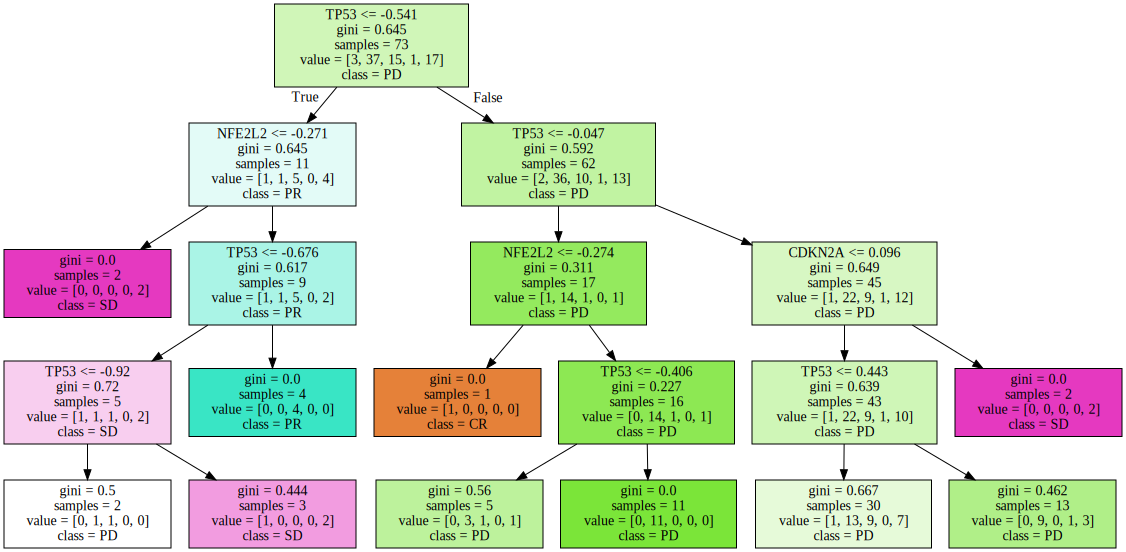

In [30]:
graph

### Phenotype and mutation data




In [31]:
def select_phenotype_columns(X):
    """
    Pass everything through.
    """ 
    return X

In [32]:
pipelines = build_pipelines(select_phenotype_columns)

In [33]:
results_all_features = compare_pipelines(pipelines)
results_all_features.index = classifier_names

In [34]:
print('Trained on all features')
results_all_features

Trained on all features


,train acc.,test acc.
tree,0.767123,0.37500
forest,0.739726,0.59375
gradient boost,1.000000,0.50000


In [35]:
print('Trained only on phenotype data')
results_pheno_only

Trained only on phenotype data


,train acc.,test acc.
tree,0.767123,0.4375
forest,0.849315,0.5625
gradient boost,0.972603,0.5000


In [36]:
# First pipeline contains decision tree classifier.
name, tree_classifier = pipelines[0].steps[-1]
# Generate names of columns after the pipeline transformation.
new_column_names = generate_feature_names(categorical_input_columns, X_train.columns)

In [37]:
import graphviz

dot_data = export_graphviz(
    tree_classifier, 
    out_file=None,
    filled=True,
    feature_names=new_column_names,
    class_names=tree_classifier.classes_,
) 
graph = graphviz.Source(dot_data)


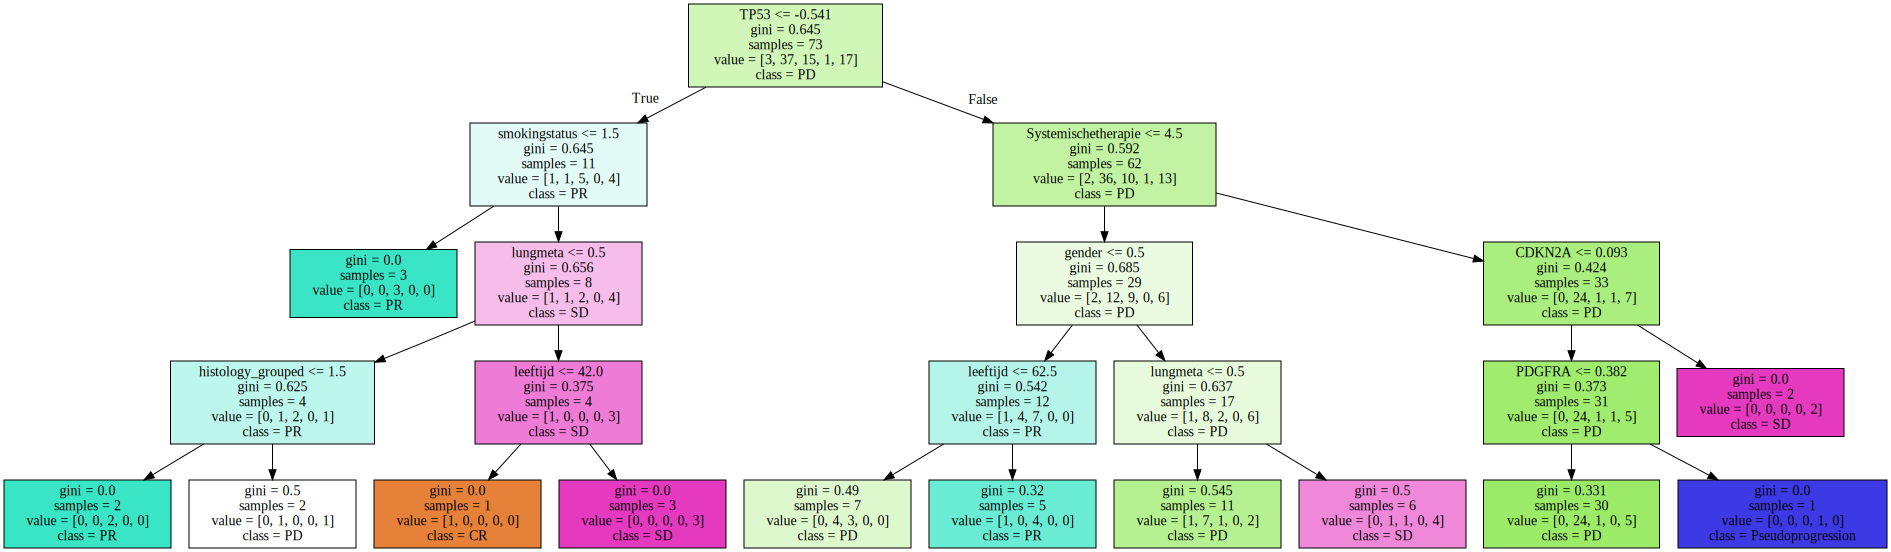

In [38]:
graph

## Head to tail pipeline
Investigate whether first classifying only phenotype data, and then a second classifier with the mutations is able to perform much better.

In [39]:
# Phenotype pipeline.
phenotype_tree_classifier = DecisionTreeClassifier(max_depth=3)
phenotype_pipeline = Pipeline(steps=[
    ("select_columns", FunctionTransformer(select_phenotype_columns, validate=False)),
    ("transform_columns", preprocess), 
    ("classify", ClassifierAsTransformer(classifier=phenotype_tree_classifier)),
])

In [40]:
#  Head-to-tail pipeline.
union = FeatureUnion(
    [
        (
            "mutation_filter",
            FunctionTransformer(select_frequent_mutation_columns, validate=False),
        ),
        ("phenotype_classifier", phenotype_pipeline),
    ]
)
feature_names = tuple(frequent_mutations) + ('pheno_predict',)

In [41]:
final_classifier = DecisionTreeClassifier(max_depth=5)
p = Pipeline(
    steps=[
        ("first_classifier_union", union),
        ("secondary_classifier", final_classifier),
    ]
)

In [42]:
p.fit(X_train, y_train)
# Calculate training and testing scores.
[p.score(X_train, y_train), p.score(X_test, y_test)]

[0.821917808219178, 0.40625]

In [43]:
import graphviz

dot_data = export_graphviz(
    final_classifier, 
    out_file=None,
    filled=True,
    feature_names=feature_names,
    class_names=tree_classifier.classes_,
) 
graph = graphviz.Source(dot_data)


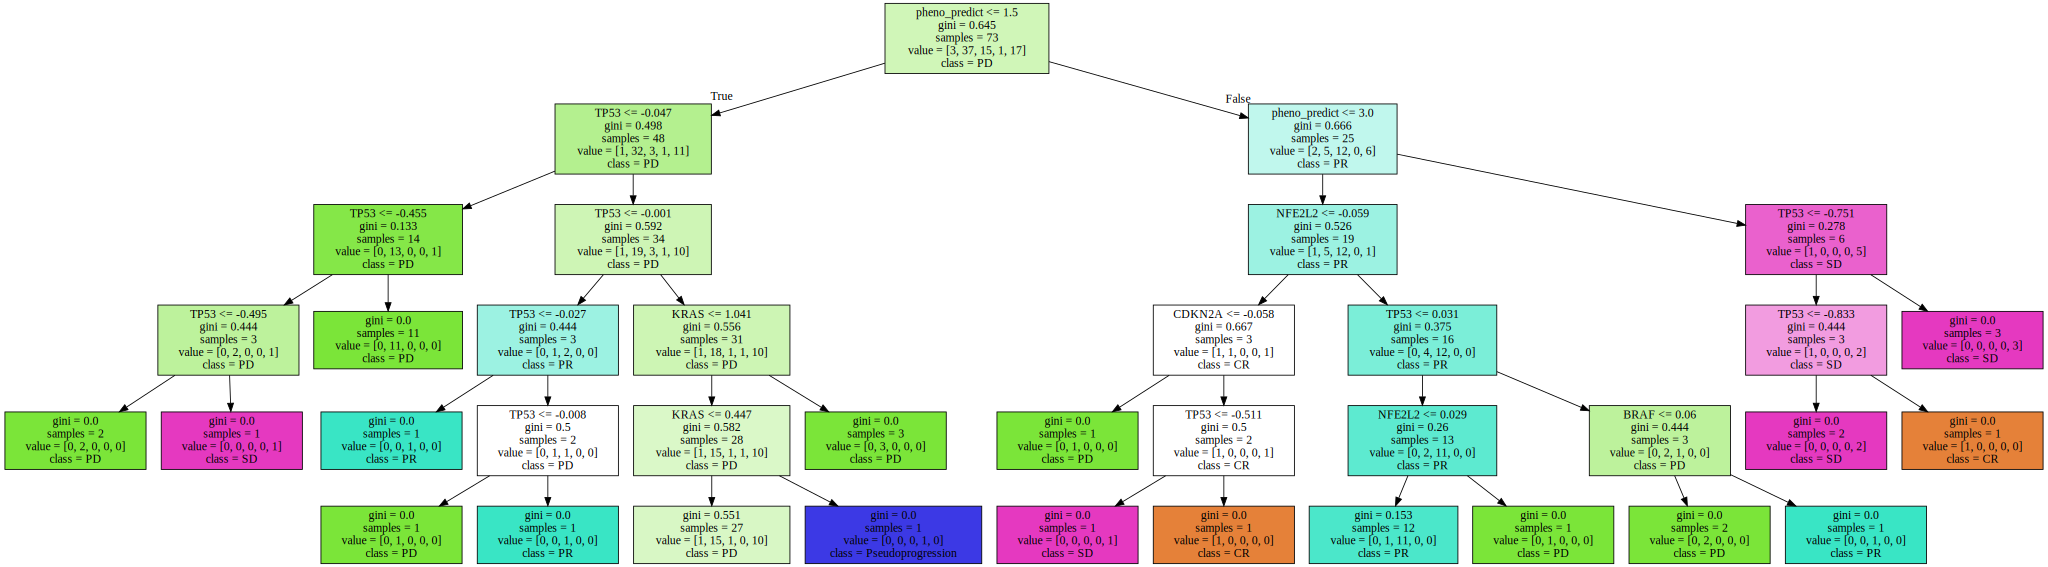

In [44]:
graph